In [1]:
print("""
@File         : 04_training_linear_models.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-03-22 21:26:39
@Email        : cuixuanstephen@gmail.com
@Description  : 训练模型
""")


@File         : 04_training_linear_models.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-03-22 21:26:39
@Email        : cuixuanstephen@gmail.com
@Description  : 训练模型



## 设置

In [2]:
import numpy as np

In [3]:
import sys
assert sys.version_info >= (3, 7)

In [4]:
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse('1.0.1')

In [5]:
import matplotlib.pyplot as plt

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "training_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

# 线性回归

## 多项式回归 Polynomial Regression

如果你的数据比直线更复杂怎么办？令人惊讶的是，你可以使用线性模型来拟合非线性数据。一个简单的方法就是将每个特征的幂次方添加为一个新特征，然后在此扩展特征集上训练一个线性模型。这种技术称为**多项式回归**。

In [6]:
import numpy as np

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

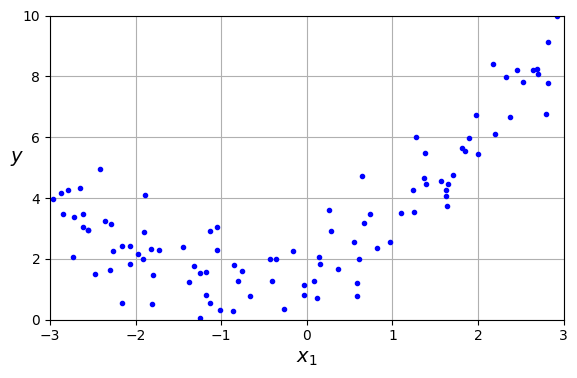

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_data_plot")
plt.show()

In [8]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [9]:
X_poly[0]

array([-0.75275929,  0.56664654])

`X_poly` 现在包含 `X` 的原始特征以及该特征的平方。

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

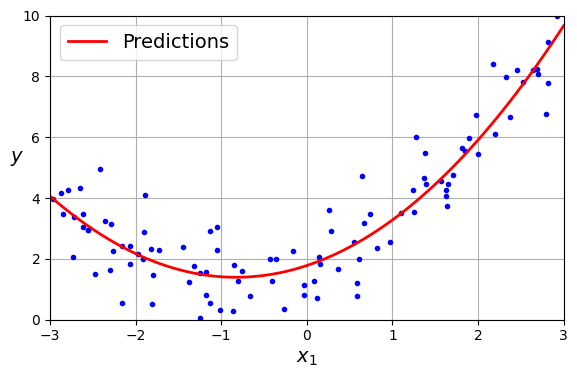

In [11]:
X_new = np.linspace(-3, 3, 100).reshape(-1, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("quadratic_predictions_plot")
plt.show()

`PolynomialFeatures(degree=d)` transforms an array containing $n$ features into an array containing $\frac{(n + d)!}{d!n!}$ features. Beware of the combinatorial explosion of the number of features!

## 学习曲线 Learning Curves

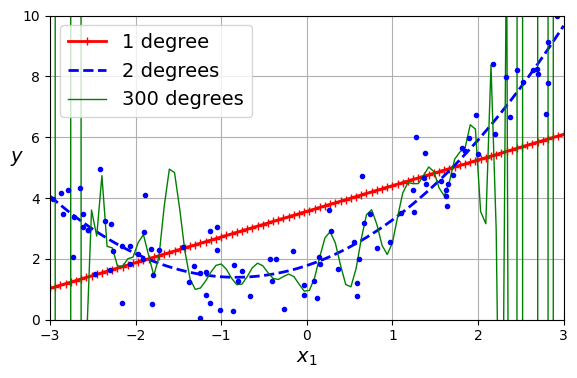

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))
for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    poly_big_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(poly_big_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_new_big = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_new_big, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
save_fig("high_degree_polynomials_plot")
plt.show()

这种高阶多项式回归模型严重过拟合训练数据，而线性模型则欠拟合。

可以使用交叉验证来估计模型的泛化性能。如果模型在训练数据上表现良好，但根据交叉验证的指标泛化较差，则你的模型过拟合。如果两者的表现均不理想，则说明欠拟合。这是一种区别模型是否过于简单或过于复杂的方法。

还有一种方法是观察学习曲线：这个曲线绘制的是模型在训练集和验证集上关于训练集大小（或训练迭代）的性能函数。要生成这个曲线，只需要在不同大小的训练子集上多次训练模型即可。

如果模型无法增量训练（即，如果它不支持 `partial_fit()` 或 `warm_start`），那么您必须在逐渐增大的训练集子集上对其进行多次训练。

Scikit-Learn 有一个有用的 `learning_curve()` 函数来帮助解决这个问题：它使用交叉验证来训练和评估模型。 默认情况下，它会在训练集的增长子集上重新训练模型，但如果模型支持增量学习，您可以在调用 `learning_curve()` 时设置 `exploit_incremental_learning=True`，它将增量训练模型。 该函数返回评估模型时的训练集大小，以及针对每个大小和每个交叉验证折叠测量的训练和验证分数。

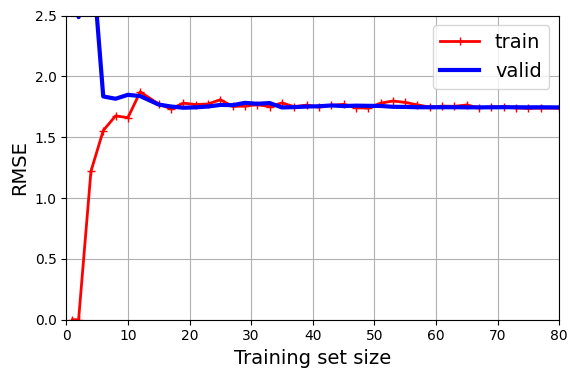

In [13]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(),
    X,
    y,
    train_sizes=np.linspace(0.01, 1.0, 40),
    cv=5,
    scoring="neg_root_mean_squared_error",
)
# train_scores 是 (40, 5) 的数组
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
save_fig("underfitting_learning_curves_plot")

plt.show()

如果你的模型欠拟合训练数据，添加更多训练示例将无济于事。你需要使用更复杂的模型或提供更好的特征。

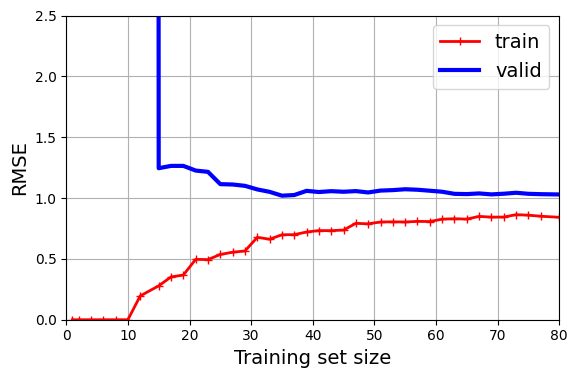

In [14]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False), LinearRegression()
)
train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression,
    X,
    y,
    train_sizes=np.linspace(0.01, 1, 40),
    cv=5,
    scoring="neg_root_mean_squared_error",
)
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
save_fig("learning_curves_plot")
plt.show()

这些学习曲线看起来有点像以前的曲线，但是有两个非常重要的区别：
- 与线性回归模型相比，训练数据上的误差要低得多。
- 曲线之间存在间隙。这意味着该模型在训练数据上的性能要比在验证数据上的性能好得多，这是过拟合模型的标志。但是，如果你使用更大的训练集，则两条曲线会继续接近。

改善过拟合模型的一种方法是向其提供更多的训练数据，直到验证误差达到训练误差为止。

**偏差/方差权衡**

统计学和机器学习的重要理论成果是以下事实：模型的泛化误差可以表示为三个非常不同的误差之和：

- 偏差 这部分泛化误差的原因在于错误的假设，比如假设数据是线性的，而实际上是二次的。高偏差模型最有可能欠拟合训练数据[1]。
- 方差 这部分是由于模型对训练数据的细微变化过于敏感。具有许多自由度的模型（例如高阶多项式模型）可能具有较高的方差，因此可能过拟合训练数据。
- 不可避免的误差 这部分误差是因为数据本身的噪声所致。减少这部分误差的唯一方法就是清理数据（例如修复数据源（如损坏的传感器），或者检测并移除异常值）。

增加模型的复杂度通常会显著提升模型的方差并减少偏差。反过来，降低模型的复杂度则会提升模型的偏差并降低方差。这就是为什么称其为权衡。

## 逻辑回归

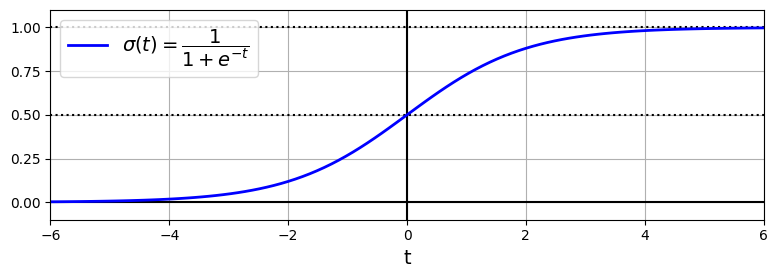

In [8]:
lim = 6
t = np.linspace(-lim, lim, 100)
sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(8, 3))
plt.plot([-lim, lim], [0, 0], "k-")
plt.plot([-lim, lim], [0.5, 0.5], "k:")
plt.plot([-lim, lim], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \dfrac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left")
plt.axis([-lim, lim, -0.1, 1.1])
plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.grid()
save_fig("logistic_function_plot")
plt.show()

### 决策边界

In [9]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [10]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [11]:
iris.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [12]:
iris.target.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

In [13]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [14]:
X = iris.data[['petal width (cm)']].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [15]:
# reshape to get a column vector
X_new = np.linspace(0, 3, 100).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
# 找到第一个大于概率大于 0.5 的 X_new
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

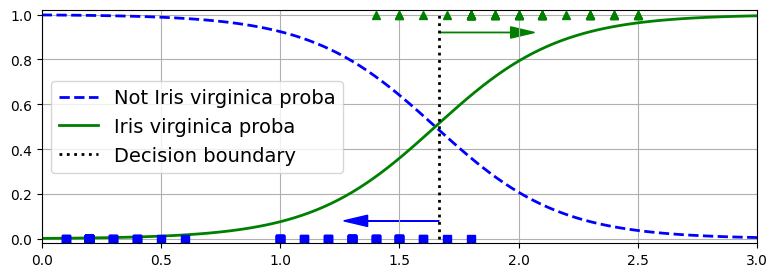

In [16]:
plt.figure(figsize=(8, 3))
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot(
    [decision_boundary, decision_boundary],
    [0, 1],
    "k:",
    linewidth=2,
    label="Decision boundary",
)

plt.arrow(
    x=decision_boundary,
    y=0.08,
    dx=-0.3,
    dy=0,
    head_width=0.05,
    head_length=0.1,
    fc="b",
    ec="b",
)
plt.arrow(
    x=decision_boundary,
    y=0.92,
    dx=0.3,
    dy=0,
    head_width=0.05,
    head_length=0.1,
    fc="g",
    ec="g",
)
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.axis([0, 3, -0.02, 1.02])
plt.grid()
save_fig("logistic_regression_plot")
plt.show()

In [17]:
decision_boundary

1.6666666666666667

In [18]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

控制 Scikit-Learn `LogisticRegression` 模型的正则化强度的超参数不是 `alpha`（其他线性模型是 `alpha`），而是它的倒数 `C`。`C` 值越高，对模型的正则化越少。

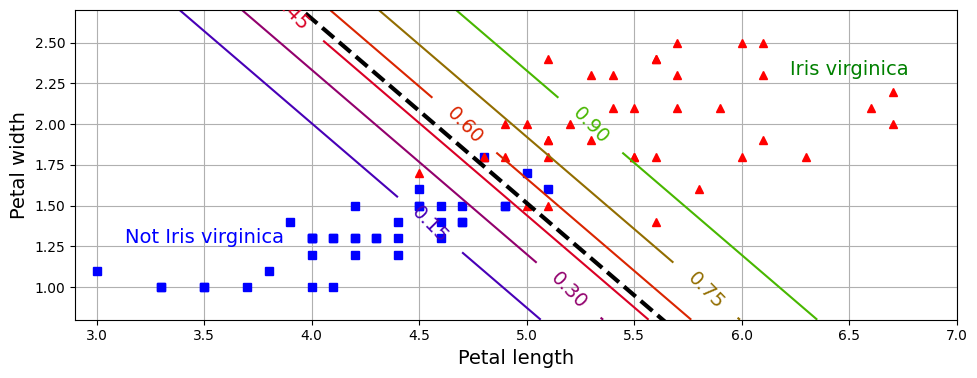

In [34]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == "virginica"
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

x0, x1 = np.meshgrid(
    np.linspace(2.9, 7, 500).reshape(-1, 1), np.linspace(0.8, 2.7, 200).reshape(-1, 1)
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_proba = log_reg.predict_proba(X_new)
# assert x0.shape == x1.shape
zz = y_proba[:, 1].reshape(x0.shape)

left_right = np.array([2.9, 7])
boundary = -(
    (log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0, 1]
)

plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "r^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
save_fig("logistic_regression_contour_plot")
plt.show()

### Softmax回归
逻辑回归模型经过推广，可以直接支持多个类别，而不需要训练并组合多个二元分类器。这就是 Softmax 回归，或者叫作多元逻辑回归。

原理很简单：给定一个实例 $x$，Softmax 回归模型首先计算出每个类 $k$ 的分数 $s_k(\bm{x})$，然后对这些分数应用 softmax 函数（也叫归一化指数），估算出每个类的概率。计算 $s_k(\bm{x})$ 分数的公式看起来就跟线性回归预测的方程一样：

$$s_k(\bm{x})=\left(\bm{\theta}^{(k)}\right)^T\bm{x}$$

请注意，每个类都有自己的特定参数向量 $\bm{\theta}^{(k)}$。所有这些向量通常都作为行存储在参数矩阵 $\Theta$ 中。

一旦为实例 $x$ 计算了每个类的分数，就可以通过 softmax 函数来估计实例属于类 $k$ 的概率。该函数计算每个分数的指数，然后对其进行归一化（除以所有指数的总和）。分数通常称为对数或对数奇数（尽管它们实际上是未归一化的对数奇数）。

$$\bar{p}_k = \sigma(\bm{s}(\bm{x}))_k=\frac{\exp(s_k(\bm{x}))}{\sum_{j=1}^K\exp(s_k(\bm{x}))}$$

Softmax 回归分类预测：

$$\hat{y}=\underset{k}\argmax~\sigma(\bm{s}(\bm{x}))_k=\underset{k}\argmax~s_k(\bm{x})=\underset{k}\argmax~\left(\left(\bm{\theta}^{(k)}\right)^T\bm{x}\right)$$

Softmax 回归分类器一次只能预测一个类（即它是多类，而不是多输出），因此它只能与互斥的类（例如不同类型的植物）一起使用。你无法使用它在一张照片中识别多个人。

通过将的成本函数（也叫作交叉熵）最小化来实现这个目标，因为当模型对目标类做出较低概率的估算时会受到惩罚。交叉熵经常被用于衡量一组估算出的类概率跟目标类的匹配程度。

$$J(\Theta)=-\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^Ky_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)$$

`LogisticRegression` classifier uses softmax regression automatically when you train it on more than two classes (assuming you use `solver="lbfgs"`, which is the default). 

In [38]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=30, random_state=42)

In [39]:
softmax_reg.predict([[5, 2]])

array([2])

In [40]:
softmax_reg.predict_proba([[5, 2]]).round(2)

array([[0.  , 0.03, 0.97]])

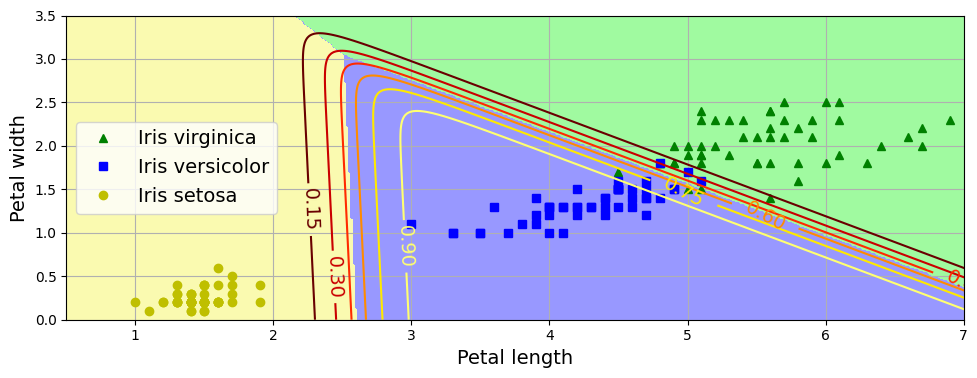

In [51]:
custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])
x0, x1 = np.meshgrid(
    np.linspace(0, 8, 500).reshape(-1, 1), np.linspace(0, 3.5, 200).reshape(-1, 1)
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")
plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
save_fig("softmax_regression_contour_plot")
plt.show()